# Astro 528, Lab 7, Exercise 3
## GPU Computing III:  Custom GPU Kernels

In this lab exercise, you'll see how to write a GPU kernel using a fairly low-level interface. This assumes that you've successfully gotten GPUs working with Julia from [exercise 1](ex1.ipynb).  Again, students are advised to run the exercises in this lab on ICS-ACI rather than their own system.  

The ICS-ACI Jupyter notebook server and interactive desktop provided by the ICS-ACI portal are now using interactive notes that include a GPU, and students should be able to run all the code there.  However, the GPUs on the interactive nodes are relatively modest GPUs.  You may want to go ahead and submit ex3.pbs, so that it can queue and run on a CyberLAMP GPU node while you work through this notebook.  Then you can review the output to compare the results and performance of the GPUs on the interactive node to that of the CyberLAMP GPU nodes.  For submitting jobs, you'll use the [command line interface](https://ics.psu.edu/computing-services/ics-aci-user-guide/#05-00-basics-aci-resources) to submit the PBS jobs, following a similar syntax as the [lab's 6 README](https://github.com/PsuAstro528/lab6-start/blob/master/README.md).  

## Setting up
First, we'll make sure that `CUDAHOME` is set, activate the project in the current directory and load packages to be used. Here we assume that you've already instantiated this project during exercise 1.

In [1]:
if haskey(ENV,"CUDAHOME")
    println("The CUDAHOME environment variable has been set to: ",ENV["CUDAHOME"])
else
    println("The CUDAHOME environment variable has not been set.  Setting it now...")
    ENV["CUDAHOME"] = "/gpfs/group/ebf11/default/astro528/cuda"
end

The CUDAHOME environment variable has not been set.  Setting it now...


"/gpfs/group/ebf11/default/astro528/cuda"

In [2]:
using Pkg
Pkg.activate(".")

"/storage/home/l/len56/lab7-lenun/Project.toml"

In [3]:
using CUDAnative,CuArrays

In [4]:
using BenchmarkTools

## Explicit GPU Kernels
In exercise 2, we wrote Julia functions and let the CuArrays and GPUArrays packages work behind the scenes to turn them into GPU kernels for us.
In this exercise, we'll write some simple GPU kernels ourselves, in an effort to better understand how GPUs work.

First, we'll write a kernel that initializes an CuArray on the GPU (rather than on the CPU) to take on values evenly spaced between a minimum and maximum values.  For starters, we might write the following.

In [5]:
function init_1d_grid!(out,N::Integer,min=-1,max=1)
    @assert length(out) == N
    i = threadIdx().x
    @inbounds out[i] = min+(max-min)*(i-1)/(N-1)
    return nothing
end

init_1d_grid! (generic function with 3 methods)

To be a valid GPU kernel, a julia function needs to:
- return nothing, 
- protect array operations with `@inbounds`,
- have no named parameters, 
- all argument types must be isbitstype(T)==true (basically contain no pointers), 
- avoid error handling like exceptions, print messages, or exiting, and
- not call functions that violated any of the above (effecitvely excluding many common functions).
Since we normally want it to do something, we typically pass at least one CuArray or CuDeviceArray that the kernel will write its output into.  Since many threads are running the same code at once, there needs to be a way for each thread to know what part of the work it should do.  The `threadIdx()` function provides the x, y and z coordinate of each thread within a block.  In the first version about, the kernel simply writes to the array location given by `threadIdx().x`.  We can launch a GPU kernel using the `@cuda` macro from CUDAnative.  Let's try that and see what happens.

In [6]:
N = 2^4
grid_1d_d = cuzeros(N);
@cuda init_1d_grid!(grid_1d_d, N) 
grid_1d_d

16-element CuArray{Float32,1}:
 -1.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

Since we didn't specify a number of threads or blocks, it defaulted to launching just one thread and one block.  Next, we'll launch the kernel with 8 threads per block and a single block.  Before running the code a each cell, think about what you expect to happen.

In [7]:
@cuda threads=8 init_1d_grid!(grid_1d_d, N) 
grid_1d_d

16-element CuArray{Float32,1}:
 -1.0       
 -0.8666667 
 -0.73333335
 -0.6       
 -0.46666667
 -0.33333334
 -0.2       
 -0.06666667
  0.0       
  0.0       
  0.0       
  0.0       
  0.0       
  0.0       
  0.0       
  0.0       

Since we launched 8 thread, we successfully wrote into the first 8 elements of the out Array.  Typically, we want to write to every element of the output array.  We can't necessarily have the same number of threads and array elements, so we can have each thread loop over array indices, so as to ensure that the full array is reached.  For example, we could tell each thread to write to the array index corresponding to (the x coordinate of) its own thread index and to array indices corresponding to that plus the size of the thread block.

In [8]:
function init_1d_grid!(out,N::Integer,min=-1,max=1)
    @assert length(out) == N
    index = threadIdx().x
    stride = blockDim().x
    for i = index:stride:length(out)
        @inbounds out[i] = min+(max-min)*(i-1)/(N-1)
    end
    return nothing
end

init_1d_grid! (generic function with 3 methods)

In [9]:
@cuda threads=8 init_1d_grid!(grid_1d_d, N) 
grid_1d_d

16-element CuArray{Float32,1}:
 -1.0       
 -0.8666667 
 -0.73333335
 -0.6       
 -0.46666667
 -0.33333334
 -0.2       
 -0.06666667
  0.06666667
  0.2       
  0.33333334
  0.46666667
  0.6       
  0.73333335
  0.8666667 
  1.0       

The code above assumes that there's only one block running.  If there were multiple blocks launched, then we'd want to make sure that different threads down't duplicate work (wasteful) or overwrite each other (dangerous).  The kernel below shows a better way to choose the indicies that the kernel writes to.  Note that it still assumes that the number of threads per block is of the form (N,1,1) and the number of blocks is of the form (M,1,1). You can think of this as using a 1dimensional block and 1-d grid of blocks.  This makes a lot of sense for 1-d arrays, but won't always be the case (e..g, when working with 2-d arrays).

In [10]:
function init_1d_grid!(out,N::Integer,min=-1,max=1)
    @assert length(out) == N
    index = (blockIdx().x -1)*blockDim().x + threadIdx().x
    stride = blockDim().x*gridDim().x
    for i = index:stride:length(out)
        @inbounds out[i] = min+(max-min)*(i-1)/(N-1)
    end
    return nothing
end

init_1d_grid! (generic function with 3 methods)

In [11]:
@cuda threads=8 init_1d_grid!(grid_1d_d, N) 
grid_1d_d

16-element CuArray{Float32,1}:
 -1.0       
 -0.8666667 
 -0.73333335
 -0.6       
 -0.46666667
 -0.33333334
 -0.2       
 -0.06666667
  0.06666667
  0.2       
  0.33333334
  0.46666667
  0.6       
  0.73333335
  0.8666667 
  1.0       

At this point, our code won't be very fast because we're using only a single block.  As a result our calculations can only be performed by a single multiprocessor on the GPU.  In order to use all of the GPU's computing resources, we need to divide the work into at least as many blocks as there are multiprocessors.  We can also specify the number of blocks when we launch a kernel using the `@cuda` macro as shown below.  We'll choose the number of blocks so that product of the number of threads per block and number of blocks exceeds the array size.  That way each thread will only need to do a single calculation.

In [12]:
N = 2^10
grid_1d_d = cuzeros(N);
num_thr = 8
num_blk = ceil(Int,N//num_thr)
@cuda threads=num_thr blocks=num_blk init_1d_grid!(grid_1d_d, N)
grid_1d_d

1024-element CuArray{Float32,1}:
 -1.0       
 -0.99804497
 -0.99608994
 -0.9941349 
 -0.9921799 
 -0.99022484
 -0.9882698 
 -0.9863148 
 -0.98435974
 -0.9824047 
 -0.9804497 
 -0.97849464
 -0.9765396 
  ⋮         
  0.97849464
  0.9804497 
  0.9824047 
  0.98435974
  0.9863148 
  0.9882698 
  0.99022484
  0.9921799 
  0.9941349 
  0.99608994
  0.99804497
  1.0       

## Example Application:  Stellar limb darkening  (CPU version)
Soon, we'll write a 2-d GPU kernel.  But first, we should make a kernel function for CPU calculations, so we'll hav something to compare to.  Below are function to compute the surface brightness of a limb-darkened stellar disk.

In [13]:
"Quadratic limb darkening law.  Takes μ = cos(angle between observer and center of star) and LD parameters, u1 and u2."
limb_darkening(μ, u1, u2) = zero(μ) <= μ <= one(μ) ? one(μ)-u1*(1-μ)-u2*(1-μ)^2 : zero(μ)

"Quadratic limb darkening law.  Takes x,y location on disk and LD parameters, u1 and u2."
function limb_darkening(x, y, u1, u2)
   r2 = x*x+y*y
   r2 < one(r2) ? limb_darkening(sqrt(1-r2),u1,u2) : zero(r2)
end

limb_darkening

We can use these as the kernel to a `mapreduce` calculation on the CPU as shown below.

In [14]:
"Integrate over smooth stellar disk assumingn quadratic limb darkening law.  Uses N^2 evaluations over square."
function calc_intensity_normalization(; u1=0.4, u2=0.26, N=256)
    grid = range(-1,stop=1,length=N)
    f(t::Tuple) = limb_darkening(t[1], t[2], u1, u2)
    sum = mapreduce(f, +, ((x,y) for x in grid, y in grid)  )    
    sum *= pi / length(grid)^2
end

calc_intensity_normalization

In [15]:
cin_cpu = calc_intensity_normalization(N=2^12)
@benchmark cin_cpu = calc_intensity_normalization(N=2^12) samples=3

BenchmarkTools.Trial: 
  memory estimate:  320 bytes
  allocs estimate:  10
  --------------
  minimum time:     126.362 ms (0.00% GC)
  median time:      126.559 ms (0.00% GC)
  mean time:        126.560 ms (0.00% GC)
  maximum time:     126.758 ms (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

## Stellar limb darkening  (GPU version)
Remember that there are several restrictions on GPU kernels.  Since the standard `sqrt` function includes error checking (looking for negative arguments), it's not allowed.  But CUDAnative provides a version of `sqrt` that can run on the GPU.  So we'll make a version of the limb darkeneing function for the GPU.

In [16]:
function limb_darkening_gpu(x, y, u1, u2)
    r2 = x*x+y*y
   return r2 <= one(r2) ? limb_darkening(CUDAnative.sqrt(one(r2)-r2),u1,u2) : zero(r2)
end

limb_darkening_gpu (generic function with 1 method)

As it is that function takes and returns scalars.  For the GPU kernel, we need to direct the GPU how to assign work to each thread. 
    Below is one possible way to divide the work, potentially making use of a 2-D arrangement of threads within a block and 2-d grid of blocks.

In [17]:
function apply_2d_grid!(out::AbstractArray{T,2},N::Integer,f,min=-1,max=1) where T<:Number
    @assert size(out,1) == N
    @assert size(out,2) == N
    index_x = (blockIdx().x -1)*blockDim().x + threadIdx().x
    stride_x = blockDim().x*gridDim().x
    index_y = (blockIdx().y -1)*blockDim().y + threadIdx().y
    stride_y = blockDim().y*gridDim().y
    for i = index_x:stride_x:size(out,1)
        for j = index_y:stride_y:size(out,2)
            x = min+(max-min)*(i-1)/(N-1)
            y = min+(max-min)*(j-1)/(N-1)
            @inbounds out[i,j] = f(x,y) 
        end
    end
    return nothing
end

apply_2d_grid! (generic function with 3 methods)

Next, we'll write a function to launch that GPU, specifying `N`, the number of samples along each axis (i.e., a total of $N^2$ evaluations), limb darkening parameters and optionally a CuAray that the result can be stored in.

In [18]:
function calc_intensity_normalization_gpu(; u1=0.4, u2=0.26, N=256, gpu_workspace = cuzeros(N,N) )
    thr = 8
    blk = ceil(Int32,N//thr)
    @cuda threads=(thr,thr) blocks=(blk,blk) apply_2d_grid!(gpu_workspace,N, 
            (x,y)->limb_darkening_gpu(x,y,u1,u2) )
    reduce(+,gpu_workspace) * pi / N^2
end

calc_intensity_normalization_gpu (generic function with 1 method)

Let's test our function.

In [19]:
N= 2^12
grid_2d_d = cuzeros(N,N)
cin_gpu = calc_intensity_normalization_gpu(N=N,gpu_workspace=grid_2d_d)

2.0304885f0

Assuming that the test worked, proceed to benchmark the function.

In [20]:
@benchmark calc_intensity_normalization_gpu(N=N,gpu_workspace=grid_2d_d) samples=3

BenchmarkTools.Trial: 
  memory estimate:  3.44 KiB
  allocs estimate:  94
  --------------
  minimum time:     36.443 ms (0.00% GC)
  median time:      36.467 ms (0.00% GC)
  mean time:        36.472 ms (0.00% GC)
  maximum time:     36.505 ms (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

How does performance of the GPU version compare to the CPU version?  What about if you run this on a CyberLAMP GPU node?

INSERT RESPONCE **The runtime was about 36 ms.**

If you're feeling overwhelmed, then you can stop here.  On the other hand, if you think you might use this technique in your project, then you'll probably want to follow along below to see an example of performing a non-trivial calculation on the GPU efficiently.

## An Absorption line
Next we'll write several small functions that can be called by a GPU kernel, so that it can compute the spectrum of a star with both an absorption line and a star spot.  First, we'll create a Gaussian absorption line.

In [21]:
"Gaussian absorption line.  Named parameters for line loc[ation], width and depth."
gaussian_line(x;loc=zero(x),width=one(x),depth=one(x)) = one(x) - depth*exp(-((x-loc)/width)^2/2)

gaussian_line

In [22]:
"Gaussian absorption line.  Named parameters for line loc[ation], width and depth."
gaussian_line_gpu(x,loc=zero(x),width=one(x),depth=one(x)) = one(x) - depth*CUDAnative.exp(-((x-loc)/width)^2/2)

gaussian_line_gpu

In [23]:
"Calc thermal width of absorption line.  Named parameters for lambda, T[emperature], Z (atomic mass), and v_turb[ulent]."
function line_width_thermal(;lambda=1, Z=1, T=5778, v_turb=0 )
   k_B = 1.3806485279e-23 # J/K
   m_H = 1.6737236e-27 # kg
   c = 299792458 # m/s
   sqrt(2k_B/m_H *T/Z + v_turb^2 )*lambda/c
end
frac_line_width_Fe = line_width_thermal(Z=55.845)

4.358033990268194e-6

In [24]:
using Plots
# pyplot() # Uncomment in you have trouble with default plotting backend

Let's create a range of wavelengths and make a quick plot to make sure our `gaussian_line` function is working as we expect.

In [25]:
lambda_min = 5549.8
lambda_max = 5550.2
lambda_mid = (lambda_min+lambda_max)/2
num_lambdas = 1024
lambdas = range(lambda_min,stop=lambda_max,length=num_lambdas)

5549.8:0.00039100684261974585:5550.2

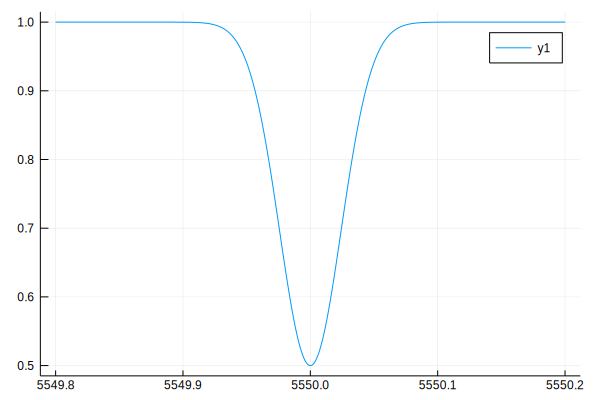

In [26]:
plot(lambdas,gaussian_line.(lambdas,loc=lambda_mid,width=lambda_mid*frac_line_width_Fe,depth=0.5))

Now we'll create some functions that allow us to compute the velocity of each patch of the stellar surface towards the observed (assumed to be along the z axis).

In [27]:
"Stellar rotation period as a function of sin(latitude).  For now assumes solid body rotation."
function rotation_period(sinlat)
    return 24.0  
end

rotation_period

In [28]:
"""   patch_velocity_los(x,y; rstar, pole ) 
Compute line of sight velocity of a patch of stellar surface given by x,y (assumed in [-1,1]).
Optional params: 
- rstar = 1: in R_sol (affects return velocity, but not x,y)
- pole = (0,1,1): unit vector with stellar rotation axis
Depends on:
- rotation_period: Function that rotation period for give cos(latitude)
"""
function patch_velocity_los(x,y; rstar=one(x), pole=(zero(x), one(x), zero(x)) ) 
  polex, poley, polez = pole
  v0 = 0.000168710673 # in (Rsol/day)/speed_of_light
  z = sqrt(one(x)-x*x-y*y)  
  sin_lat = x*polex+y*poley+z*polez
  vmax = v0*rstar/rotation_period(sin_lat) 
  vmax*(polex*y-poley*x)
end

patch_velocity_los

In [29]:
"""   patch_velocity_los_gpu(x,y; rstar, pole ) 
Compute line of sight velocity of a patch of stellar surface given by x,y (assumed in [-1,1]).
Optional params: 
- rstar = 1: in R_sol (affects return velocity, but not x,y)
- pole = (0,1,1): unit vector with stellar rotation axis
Depends on:
- rotation_period: Function that rotation period for give cos(latitude)
"""
function patch_velocity_los_gpu(x,y; rstar=one(x), pole=(zero(x), one(x), zero(x)) ) 
  polex, poley, polez = pole
  v0 = 0.000168710673 # in (Rsol/day)/speed_of_light
  z = CUDAnative.sqrt(one(x)-x*x-y*y)  
  sin_lat = x*polex+y*poley+z*polez
  vmax = v0*rstar/rotation_period(sin_lat) 
  vmax*(polex*y-poley*x)
end

patch_velocity_los_gpu

## A star spot

Now, we'll define functions that can compute the surface intensity of each patch of the star's surface near a spot (before accounting for viewing angle and limb darkening).

In [30]:
"""   spot_intensity(x,y; spot_radius, spot_contrast, spot_loc )
Compute intensity of patch of stellar surface given by x,y (assumed in [-1,1])
Returns 1-spot_contrast if in spot and 1 if outside of spot (and in stellar disk)
Optional params:
- spot_radius: radius in sin(angle between spot center and patch) (default: 0)
- spot_loc: unit vector for center of spot (default: (0,0,1) = center of disk )
- spot_contranst: fractional reduction in intensity in spot
"""
function spot_intensity(x,y; spot_radius=zero(x), spot_contrast=one(x), spot_loc=(zero(x),zero(x),one(x)) )
   r2 = x*x+y*y
   if r2 > one(r2) 
        return zero(r2)
   elseif spot_radius == zero(spot_radius)
        return one(r2)
   end
   z = sqrt(one(r2)-r2)  
   spot_x, spot_y, spot_z = spot_loc
   cos_spot_patch = x*spot_x + y*spot_y + z*spot_z
   dist_to_spot = one(r2)-cos_spot_patch^2 
   intensity = dist_to_spot > spot_radius ? one(spot_contrast) : one(spot_contrast)-spot_contrast   
end

spot_intensity

In [31]:
"""   spot_intensity(x,y; spot_radius, spot_contrast, spot_loc )
Compute intensity of patch of stellar surface given by x,y (assumed in [-1,1])
Returns 1-spot_contrast if in spot and 1 if outside of spot (and in stellar disk)
Optional params:
- spot_radius: radius in sin(angle between spot center and patch) (default: 0)
- spot_loc: unit vector for center of spot (default: (0,0,1) = center of disk )
- spot_contranst: fractional reduction in intensity in spot
"""
function spot_intensity_gpu(x,y; spot_radius=zero(x), spot_contrast=one(x), spot_loc=(zero(x),zero(x),one(x)) )
   r2 = x*x+y*y
   if r2 > one(r2) 
        return zero(r2)
   elseif spot_radius == zero(spot_radius)
        return one(r2)
   end
   z = CUDAnative.sqrt(one(r2)-r2)  
   spot_x, spot_y, spot_z = spot_loc
   cos_spot_patch = x*spot_x + y*spot_y + z*spot_z
   dist_to_spot = one(r2)-cos_spot_patch^2 
   intensity = dist_to_spot > spot_radius ? one(spot_contrast) : one(spot_contrast)-spot_contrast   
end

spot_intensity_gpu

Now, we'll write a function that runs on the CPU and returns the apparent brightness of each patch of the star's surface at a single wavelength.  We'll use this function to make a plot, to help us see what's going on.

In [32]:
""" star_map(lambda)
Computes map of stellar surface brightness for a Gaussian absorption line given limb darkening, rotation and a star spot.
Named parameters:
- u1, u2: Quadratic limb darkening parameters
- N: Number of points to evaluate in each axis (256)
- line_loc, line_width, line_depth: properties of spectral line
- spot_radius, spot_contrast, spot_loc: properties of star spot
"""
function star_map(lambda; u1=0.4, u2=0.26, N=256, 
        line_loc=0,line_width=0,line_depth=1,
        spot_radius=0, spot_contrast=1, spot_loc=(0,0,1) )
    xgrid = range(-1,stop=1,length=N)
    function surface_brightness(t::Tuple)
       x,y = t
       r2 = x*x+y*y
       if r2 > one(r2) 
          return zero(r2)
       end
       redshift = patch_velocity_los(x,y)
       spec = gaussian_line(lambda*(1+redshift), loc=line_loc,width=line_width,depth=line_depth)
       brightness = spot_intensity(x,y,
            spot_radius=spot_radius,spot_contrast=spot_contrast,spot_loc=spot_loc)
       ld = limb_darkening(sqrt(1-r2),u1,u2)
       brightness * spec * ld
    end
    map(surface_brightness, ((x,y) for x in xgrid, y in xgrid)  ) .* pi / length(xgrid)^2 
end

star_map

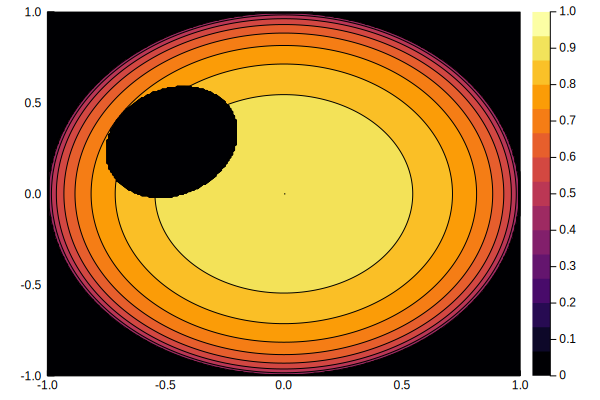

In [33]:
xgrid = range(-1,stop=1,length=256)
ygrid = range(-1,stop=1,length=256)
sm = star_map(lambda_min, line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.5,
        spot_radius=0.1,spot_loc=(-0.5,0.3,sqrt(1-0.5^2-0.3^2)) )
plot(xgrid,xgrid,sm'./maximum(sm),st=:contourf)

For most stars, we can't spatially resolve the stellar disk, so we'd just observed the disk-integrated flux.  The next function is very similar to the previous, expect that use a `mapreduce` to compute the disk-integrated flux while reducing the memory overhead.

In [34]:
""" disk_integrated_flux(lambda)
Computes disk integrated stellar flux for a Gaussian absorption line given limb darkening, rotation and a star spot.
Named parameters:
- u1, u2: Quadratic limb darkening parameters
- N: Number of points to evaluate in each axis (256)
- line_loc, line_width, line_depth: properties of spectral line
- spot_radius, spot_contrast, spot_loc: properties of star spot
"""
function disk_integrated_flux(lambda; u1=0.4, u2=0.26, N=256, 
        line_loc=0,line_width=0,line_depth=1,
        spot_radius=0, spot_contrast=1, spot_loc=(0,0,1) )
    xgrid = range(-1,stop=1,length=N)
    function surface_brightness(t::Tuple)
       x,y = t
       r2 = x*x+y*y
       if r2 > one(r2) 
          return zero(r2)
       end
       redshift = patch_velocity_los(x,y)
       spec = gaussian_line(lambda*(1+redshift), loc=line_loc,width=line_width,depth=line_depth)
       brightness = spot_intensity(x,y,
            spot_radius=spot_radius,spot_contrast=spot_contrast,spot_loc=spot_loc)
       ld = limb_darkening(sqrt(1-r2),u1,u2)
       brightness * spec * ld
    end
    sum = mapreduce(surface_brightness, +, ((x,y) for x in xgrid, y in xgrid)  )    
    sum *= pi / length(xgrid)^2 
end

disk_integrated_flux

Next, let's use the function above to compute the disk-integrated spectrum and plot it to help us see what's going on.  We'll gradually turn on features to help visualize the effects of limb darkening, stellar rotation and the spot.

In [35]:
@time spectrum_gaussian_line = gaussian_line.(lambdas,loc=lambda_mid,width=lambda_mid*frac_line_width_Fe,depth=0.5)
normalization = disk_integrated_flux(lambda_mid,line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.0)

@time spectrum_add_rotation = disk_integrated_flux.(lambdas,line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.5) ./normalization
@time spectrum_add_spot = disk_integrated_flux.(lambdas,line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.5,
        spot_radius=0.1,spot_loc=(-0.5,0.3,sqrt(1-0.5^2-0.3^2))) ./normalization;

  0.000052 seconds (17 allocations: 8.797 KiB)
  3.325436 seconds (357.51 k allocations: 17.202 MiB)
  3.428061 seconds (503.05 k allocations: 24.396 MiB, 0.39% gc time)


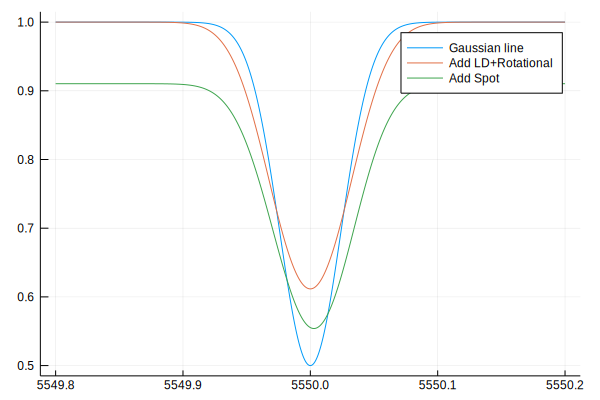

In [36]:
plot(lambdas,spectrum_gaussian_line, label="Gaussian line")
plot!(lambdas,spectrum_add_rotation, label="Add LD+Rotational")
plot!(lambdas,spectrum_add_spot, label="Add Spot")

At first glance the blue green curve may look like a standard absorption line.  But if we subtract it's mirror image, we can see that the rotation is causing an asymetry in the line shape.

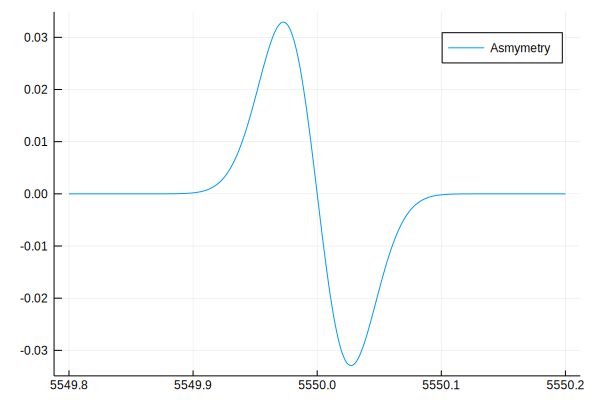

In [37]:
plot(lambdas,(spectrum_add_spot.-view(spectrum_add_spot,length(spectrum_add_spot):-1:1)),label="Asmymetry")

## Moving the calculation to the GPU
We need to make versions of the surface_brightness function that can run on the CPU.

In [38]:
function surface_brightness_gpu(x,y,lambda,line_loc,line_width,line_depth,
        spot_radius,spot_contrast,spot_loc,
        u1,u2)
       r2 = x*x+y*y
       if r2 > one(r2) 
          return zero(r2)
       end
       redshift = patch_velocity_los_gpu(x,y)
       spec = gaussian_line_gpu(lambda*(1+redshift), line_loc,line_width,line_depth)
       brightness = spot_intensity_gpu(x,y,
            spot_radius=spot_radius,spot_contrast=spot_contrast,spot_loc=spot_loc)
       ld = limb_darkening(CUDAnative.sqrt(1-r2),u1,u2)
       brightness * spec * ld
end

surface_brightness_gpu (generic function with 1 method)

Next, we need a function to launch the GPU kernel, specifying the arrangement of threads within each block and the number of blocks.  We'll also perform the reduction on the GPU, so that it only needs to return the disk-integrated flux at one wavelength.

In [39]:
function disk_integrated_flux_gpu(lambda; u1=0.4, u2=0.26, N::Integer=256, gpu_workspace = cuzeros(N,N),
        line_loc=0,line_width=0,line_depth=1,
        spot_radius=0, spot_contrast=1, spot_loc=(0,0,1)
    )
    thr = 8
    blk = ceil(Int32,N//thr)
    @cuda threads=(thr,thr) blocks=(blk,blk) apply_2d_grid!(gpu_workspace,N, 
            (x,y)->surface_brightness_gpu(x,y,lambda,line_loc,line_width,line_depth,
                                            spot_radius,spot_contrast,spot_loc,  u1,u2) )
    reduce(+,gpu_workspace) * pi / N^2
end

disk_integrated_flux_gpu (generic function with 1 method)

Let's test our GPU kernel and compare the results to the CPU version.

In [40]:
spectrum_add_spot_gpu = disk_integrated_flux_gpu.(lambdas,line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.5,
        spot_radius=0.1,spot_loc=(-0.5,0.3,sqrt(1-0.5^2-0.3^2))) /normalization;

In [41]:
minimum(abs.(spectrum_add_spot.-spectrum_add_spot_gpu))

2.248560226902896e-10

Now, benchmark the GPU and CPU versions and compare their performance.

In [42]:
@benchmark  disk_integrated_flux_gpu.(lambdas,line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.5,
        spot_radius=0.1,spot_loc=(-0.5,0.3,sqrt(1-0.5^2-0.3^2))) /normalization samples=5

BenchmarkTools.Trial: 
  memory estimate:  4.08 MiB
  allocs estimate:  122393
  --------------
  minimum time:     443.086 ms (0.00% GC)
  median time:      443.849 ms (0.00% GC)
  mean time:        443.819 ms (0.00% GC)
  maximum time:     444.458 ms (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

In [43]:
@benchmark disk_integrated_flux.(lambdas,line_loc=lambda_mid,line_width=lambda_mid*frac_line_width_Fe,line_depth=0.5,
        spot_radius=0.1,spot_loc=(-0.5,0.3,sqrt(1-0.5^2-0.3^2))) ./normalization samples=5

BenchmarkTools.Trial: 
  memory estimate:  392.56 KiB
  allocs estimate:  10251
  --------------
  minimum time:     3.218 s (0.00% GC)
  median time:      3.224 s (0.00% GC)
  mean time:        3.224 s (0.00% GC)
  maximum time:     3.230 s (0.00% GC)
  --------------
  samples:          2
  evals/sample:     1

How does the performance of the GPU compare to the the CPU version on the ACI-I server?  What about on a CyberLAMP GPU node?
If one wanted to further improve the GPU performance, what changes would likely increase the performance further?  

INSERT RESPONCE **The runtimes were about 443 ms versus 3.2 seconds.**

If you're considering writing GPU kernels for your project code, then try experimenting with the number of threads per block to see how it affects the performance.  Report your findings.
        
INSERT RESPONCE